# Price Prediction, Anomaly Detection & Clustering

Dataset: kolesa_ml_ready.csv

In [2]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans

from catboost import CatBoostRegressor
import shap
import matplotlib.pyplot as plt


In [13]:

df = pd.read_csv('../data/processed/kolesa_cleaned.csv')
df.head()


,title,price,description,city,views,url,year,mileage,engine_l,fuel,gearbox,car_age,price_per_year,price_per_km,price_z
0,ВАЗ (Lada) Lada 2121,2000000.0,"2008 г., Б/у внедорожник, 1.7 л, бензин, КПП м...",Алматы,0,https://kolesa.kz/a/show/207117446?search_id=9...,2008.0,160000.0,1.7,petrol,manual,17.0,117647.058824,12.500000,-0.596179
1,Mitsubishi Delica,8500000.0,"1995 г., Б/у минивэн, 3 л, бензин, Правый руль...",Алматы,0,https://kolesa.kz/a/show/205868127?search_id=9...,1995.0,220000.0,3.0,petrol,automatic,30.0,283333.333333,38.636364,-0.185337
2,BMW 528,6500000.0,"2012 г., Б/у седан, 2 л, бензин, КПП автомат, ...",Караганда,0,https://kolesa.kz/a/show/206593170?search_id=9...,2012.0,273000.0,2.0,petrol,automatic,13.0,500000.000000,23.809524,-0.311750
3,Toyota Camry,6050000.0,"2011 г., Б/у седан, 2.5 л, бензин, КПП автомат...",Актау,0,https://kolesa.kz/a/show/207108864?search_id=9...,2011.0,174000.0,2.5,petrol,automatic,14.0,432142.857143,34.770115,-0.340192
4,Mazda 626,1800000.0,"1998 г., Б/у универсал, 1.8 л, бензин, КПП мех...",Шымкент,0,https://kolesa.kz/a/show/207105826?search_id=9...,1998.0,444444.0,1.8,petrol,manual,27.0,66666.666667,4.050004,-0.608820


In [12]:

# Check data types and non-numeric columns
print("Data shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nNon-numeric columns:")
non_numeric = df.select_dtypes(include=['object']).columns.tolist()
print(non_numeric)


Data shape: (2020, 15)

Data types:
title              object
price             float64
description        object
city               object
views               int64
url                object
year              float64
mileage           float64
engine_l          float64
fuel               object
gearbox            object
car_age           float64
price_per_year    float64
price_per_km      float64
price_z           float64
dtype: object

Non-numeric columns:
['title', 'description', 'city', 'url', 'fuel', 'gearbox']


## Feature Engineering

In [14]:

# Drop columns that shouldn't be used for modeling
df = df.drop(['title', 'description', 'url'], axis=1)

df['mileage'] = df['mileage'].fillna(df['mileage'].median())
df['engine_l'] = df['engine_l'].fillna(df['engine_l'].median())

df['mileage_per_year'] = df['mileage'] / df['car_age'].replace(0,1)

city_price = df.groupby('city')['price'].mean()
df['city_price_index'] = df['city'].map(city_price)

df['price_per_km'] = df['price'] / df['mileage'].replace(0,1)


In [21]:
df['price_per_year'] = df['price'] / df['car_age'].replace(0, 1)


## Encoding

In [22]:

for col in ['fuel','gearbox','city']:
    df[col] = LabelEncoder().fit_transform(df[col])


## Price Prediction

In [23]:

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [24]:

# Check for infinity and NaN values
print("Infinity values:")
print((np.isinf(df)).sum())
print("\nNaN values:")
print(df.isna().sum())

# Replace infinity with NaN and then fill with median
df = df.replace([np.inf, -np.inf], np.nan)
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)


Infinity values:
price               0
city                0
views               0
year                0
mileage             0
engine_l            0
fuel                0
gearbox             0
car_age             0
price_per_year      0
price_per_km        0
price_z             0
mileage_per_year    0
city_price_index    0
dtype: int64

NaN values:
price               0
city                0
views               0
year                0
mileage             0
engine_l            0
fuel                0
gearbox             0
car_age             0
price_per_year      0
price_per_km        0
price_z             0
mileage_per_year    0
city_price_index    0
dtype: int64


In [27]:

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
print("RMSE:", rmse)
print("RF R2:", r2_score(y_test, pred))


RMSE: 571622.6194732236
RF R2: 0.9988079570327951


In [30]:

cat = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=8, verbose=False)
cat.fit(X_train, y_train)

pred = cat.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
print("CatBoost RMSE:", rmse)
print("CatBoost R2:", r2_score(y_test, pred))


CatBoost RMSE: 1433397.817710862
CatBoost R2: 0.9925043970030125


## SHAP Interpretation

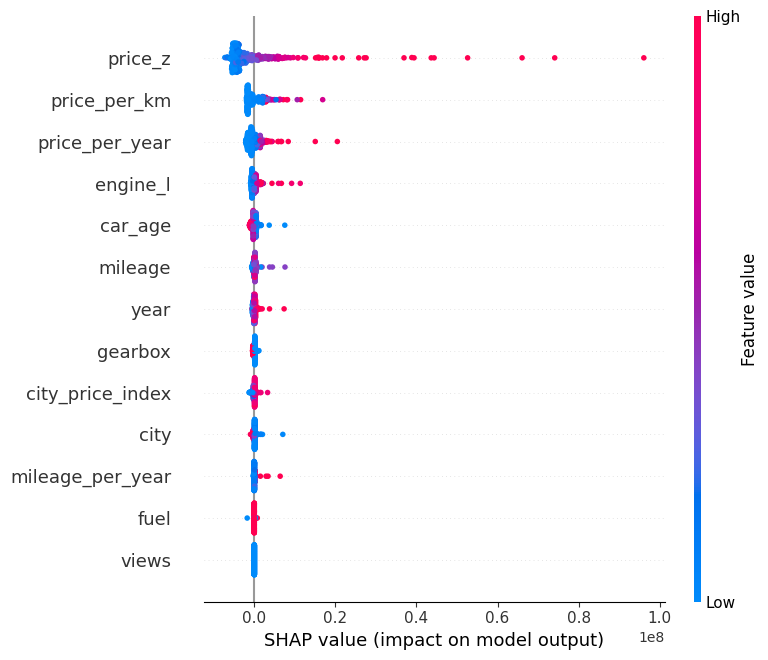

In [31]:

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


## Anomaly Detection

In [32]:

iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X)

df['z_price'] = (df['price'] - df['price'].mean()) / df['price'].std()
df[df['anomaly'] == -1].head()


,price,city,views,year,mileage,engine_l,fuel,gearbox,car_age,price_per_year,price_per_km,price_z,mileage_per_year,city_price_index,anomaly,z_price
22,22500000.0,4,0,2025.0,17.0,2.5,2,1,0.0,2.250000e+07,1.323529e+06,0.699553,17.000000,1.338713e+07,-1,0.699380
29,68500000.0,8,0,2025.0,20000.0,3.5,3,0,0.0,6.850000e+07,3.425000e+03,3.607050,20000.000000,1.543076e+07,-1,3.606157
44,185500000.0,4,0,2025.0,152800.0,4.0,3,0,0.0,1.855000e+08,1.214005e+03,11.002204,152800.000000,1.338713e+07,-1,10.999480
130,11750000.0,8,0,2025.0,28.0,1.5,3,3,0.0,1.175000e+07,4.196429e+05,0.020084,28.000000,1.543076e+07,-1,0.020079
142,1800000.0,66,0,1991.0,3333.0,2.0,3,2,34.0,5.294118e+04,5.400540e+02,-0.608820,98.029412,1.292500e+06,-1,-0.608669


## Clustering

In [33]:

cluster_features = df[['price','car_age','mileage','engine_l']]

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_features)

df.groupby('cluster')[['price','car_age','mileage']].mean()


,price,car_age,mileage
cluster,,,
0,5.595327e+06,15.536339,190629.782638
1,1.519096e+08,0.727273,101138.181818
2,5.927981e+07,3.412698,49005.730159
3,2.037575e+07,5.084783,102610.110870
